In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image


Increasing Image Size from 32 to 64 so that model can learn more complex features

In [36]:
#Define Preprocessing and Data Loading
transform = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to 32x32
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0, 0, 0], std=[1,1,1])  # Normalize to [-1, 1]
])

In [37]:
dataset = datasets.ImageFolder(root='photos', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

Increased Latent Dimension

In [ ]:
class VAE(nn.Module):
    def __init__(self, beta=1.0):
        super(VAE, self).__init__()
        self.beta = beta  # Beta for controlling KL divergence weight

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 256, 4, 4)
            nn.ReLU(),
            nn.Flatten()  # Flatten to (batch_size, 256 * 4 * 4) = (batch_size, 4096)
        )
        # Latent space layer (mu, log_var)
        self.fc_mu = nn.Linear(256 * 4 * 4,512)  # Latent mean
        self.fc_log_var = nn.Linear(256 * 4 * 4,512)  # Latent log-variance
        # Decoder
        self.decoder_fc = nn.Linear(512, 256 * 4 * 4)  # Fully connected layer to match encoder's output size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 3, 64, 64)
            nn.Sigmoid()  # Sigmoid for normalized output [0, 1]
        )
        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)  # Apply dropout with 30% probability
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc(z)  # Fully connected layer to match the decoder input size
        z = z.view(-1, 256, 4, 4)  # Reshape to (batch_size, 256, 4, 4)
        return self.decoder(z)  # Decode to (batch_size, 3, 64, 64)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var


Increasing Learning Rate 

Epoch 1/50, Total Loss: 7984.9676, Recon Loss: 7922.8785, KL Loss: 15.5223
Epoch 2/50, Total Loss: 7462.0761, Recon Loss: 7351.6070, KL Loss: 27.6173
Epoch 3/50, Total Loss: 7314.2215, Recon Loss: 7172.4423, KL Loss: 35.4448
Epoch 4/50, Total Loss: 7209.2560, Recon Loss: 7062.1139, KL Loss: 36.7855
Epoch 5/50, Total Loss: 7197.9066, Recon Loss: 7044.6100, KL Loss: 38.3242
Epoch 6/50, Total Loss: 7096.2470, Recon Loss: 6938.4146, KL Loss: 39.4581
Epoch 7/50, Total Loss: 7080.3401, Recon Loss: 6921.4837, KL Loss: 39.7141
Epoch 8/50, Total Loss: 7075.7593, Recon Loss: 6913.8750, KL Loss: 40.4711
Epoch 9/50, Total Loss: 7061.4710, Recon Loss: 6899.6946, KL Loss: 40.4441
Epoch 10/50, Total Loss: 7063.1231, Recon Loss: 6898.9838, KL Loss: 41.0348
Epoch 11/50, Total Loss: 7054.4302, Recon Loss: 6889.0009, KL Loss: 41.3573
Epoch 12/50, Total Loss: 7049.5952, Recon Loss: 6884.1681, KL Loss: 41.3568
Epoch 13/50, Total Loss: 7049.8694, Recon Loss: 6884.8863, KL Loss: 41.2458
Epoch 14/50, Total Lo

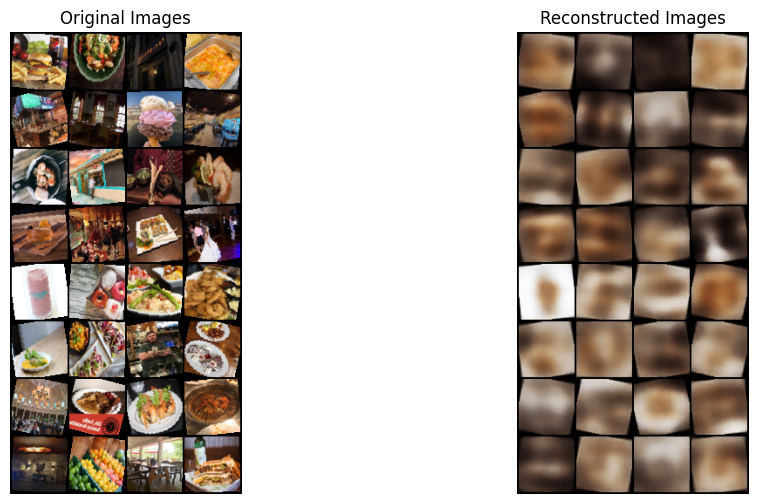

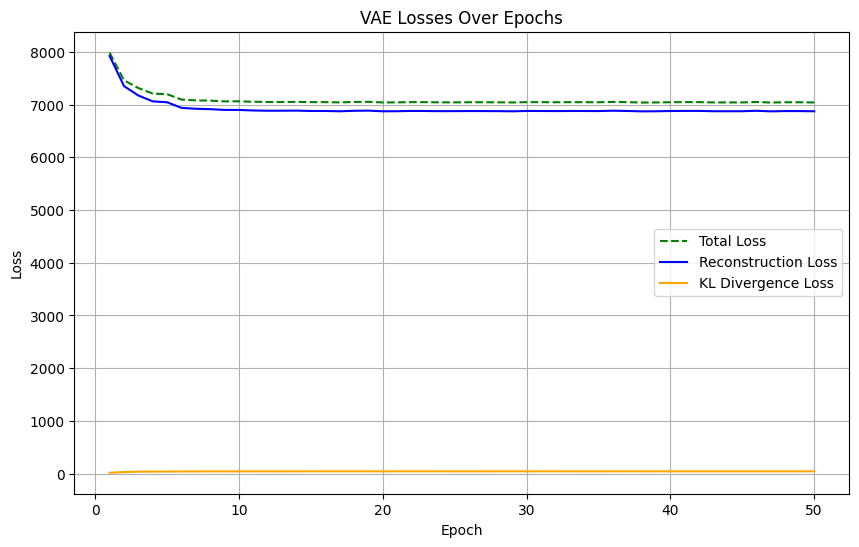

In [93]:

# Loss function with beta-VAE regularization
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    # Binary Cross-Entropy for reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64), reduction='sum')
    
    # KL divergence
    D_KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss with beta weighting for KL divergence
    total_loss = BCE + beta * D_KL
    return BCE, D_KL, total_loss

# Initialize model, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(beta=4.0).to(device)  # Increase KL loss weight (beta=4.0 as an example)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Adding weight decay for regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decays LR by 0.1 every 10 epochs

# Training loop
num_epochs = 50
train_loss, recon_loss, kl_loss = [], [], []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss, running_recon_loss, running_kl_loss = 0.0, 0.0, 0.0

    for data, _ in train_loader:  # Assuming 'train_loader' is defined elsewhere
        data = data.to(device)  # Move data to GPU/CPU

        # Forward pass
        optimizer.zero_grad()  # Clear gradients
        recon_batch, mu, log_var = model(data)

        # Compute losses
        recon_loss_batch, kl_loss_batch, total_loss = vae_loss(recon_batch, data, mu, log_var, beta=model.beta)
        total_loss.backward()  # Backpropagation
        
        # Gradient clipping (optional)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update parameters

        # Accumulate losses
        running_loss += total_loss.item()
        running_recon_loss += recon_loss_batch.item()
        running_kl_loss += kl_loss_batch.item()

    # Average loss per epoch
    train_loss.append(running_loss / len(train_loader.dataset))
    recon_loss.append(running_recon_loss / len(train_loader.dataset))
    kl_loss.append(running_kl_loss / len(train_loader.dataset))

    # Step the scheduler
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {train_loss[-1]:.4f}, "
          f"Recon Loss: {recon_loss[-1]:.4f}, KL Loss: {kl_loss[-1]:.4f}")

    # Visualize 16 images at the end of each epoch
    if (epoch + 1) % 50 == 0:  # Show images after every epoch
        model.eval()
        with torch.no_grad():
            for data, _ in train_loader:
                data = data.to(device)
                recon_images, _, _ = model(data)
                recon_images = recon_images * 0.5 + 0.5  # Denormalize images if normalized to [-1, 1]

                # Display 16 images
                grid_original = vutils.make_grid(data.cpu(), nrow=4, normalize=True)
                grid_reconstructed = vutils.make_grid(recon_images.cpu(), nrow=4, normalize=True)
                
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(grid_original.permute(1, 2, 0))
                plt.title('Original Images')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(grid_reconstructed.permute(1, 2, 0))
                plt.title('Reconstructed Images')
                plt.axis('off')
                plt.show()
                break  # Visualize for one batch only

# Loss Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, 'g--', label='Total Loss')
plt.plot(range(1, num_epochs + 1), recon_loss, 'b-', label='Reconstruction Loss')
plt.plot(range(1, num_epochs + 1), kl_loss, 'orange', label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Observations:

The total and reconstruction losses dominate the scale and converge to a stable value by around epoch 20.
The KL divergence loss is very small in comparison, which might indicate:
A weak contribution of the KL term to the total loss.
Potential issues like a vanishing KL divergence (common in VAEs).

Checking if Latent Dimension are close to zero which possibly contribution to low KL Loss

In [75]:
mu, log_var = model.encode(data)
print(f"Mu: {mu.mean()}, Log Var: {log_var.mean()}")


Mu: 3.7242202779452782e-06, Log Var: 5.932381463935599e-05


In [87]:
def vae_loss2(recon_x, x, mu, log_var, beta, eps=1e-8):
    # Binary Cross-Entropy for reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64), reduction='mean')

    # KL Divergence with small constant (stabilizing variance)
    D_KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) + eps

    # Total loss with beta weighting for KL divergence
    total_loss = BCE + beta * D_KL

    # Optionally, add a regularization term on log_var to avoid collapsing
    log_var_reg = 0.1 * torch.sum(log_var ** 2)

    total_loss += log_var_reg

    return BCE, D_KL, total_loss

Trying Annealing Beta(Gradually Increasing it with epochs)

Epoch 1/10, β: 1.00, Total Loss: 6922.9524, Recon Loss: 6881.1732, KL Loss: 41.7792
Epoch 2/10, β: 1.40, Total Loss: 6935.1147, Recon Loss: 6876.6646, KL Loss: 41.7501
Epoch 3/10, β: 1.80, Total Loss: 6951.7461, Recon Loss: 6876.4750, KL Loss: 41.8173
Epoch 4/10, β: 2.20, Total Loss: 6972.8578, Recon Loss: 6880.8461, KL Loss: 41.8235
Epoch 5/10, β: 2.60, Total Loss: 6985.5806, Recon Loss: 6876.9347, KL Loss: 41.7869
Epoch 6/10, β: 3.00, Total Loss: 7002.5988, Recon Loss: 6877.2323, KL Loss: 41.7889
Epoch 7/10, β: 3.40, Total Loss: 7014.5158, Recon Loss: 6872.3263, KL Loss: 41.8204
Epoch 8/10, β: 3.80, Total Loss: 7037.5300, Recon Loss: 6878.5086, KL Loss: 41.8478
Epoch 9/10, β: 4.20, Total Loss: 7051.4084, Recon Loss: 6876.0562, KL Loss: 41.7505
Epoch 10/10, β: 4.60, Total Loss: 7065.3833, Recon Loss: 6873.2115, KL Loss: 41.7765


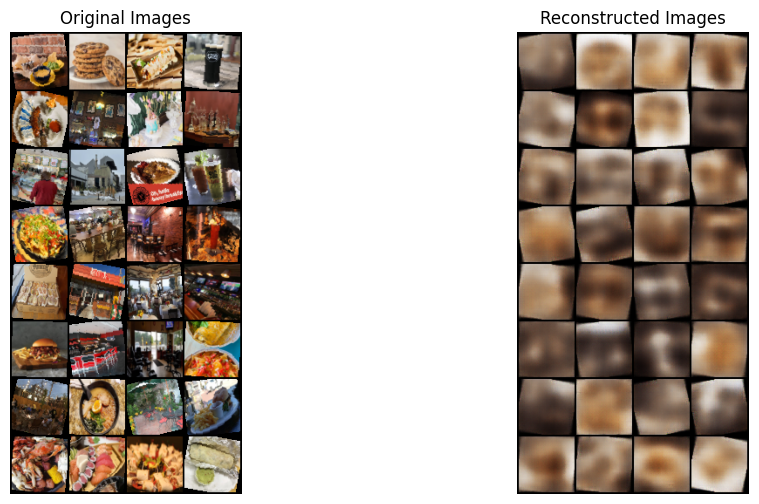

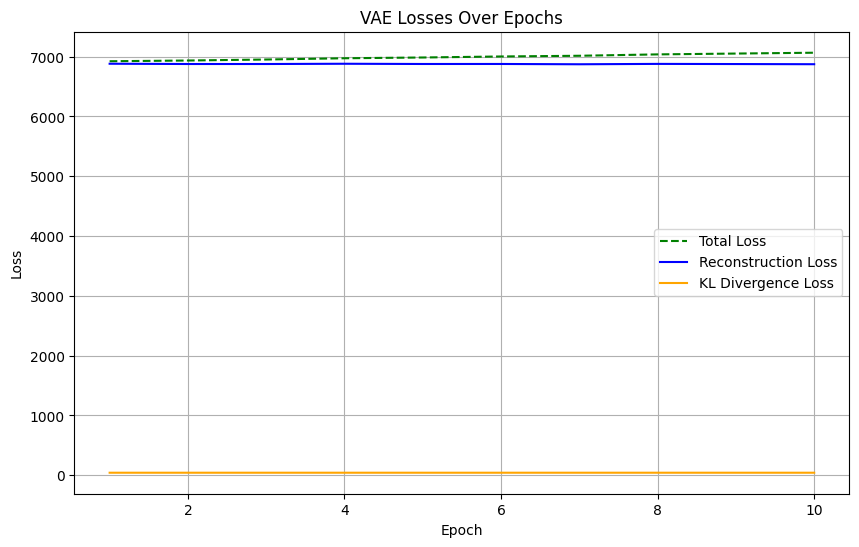

In [94]:
def annealing_beta(epoch, warmup_epochs=15, max_beta=10):
    return min(1.0 + (epoch / warmup_epochs) * (max_beta - 1.0), max_beta)
num_epochs = 10
train_loss, recon_loss, kl_loss = [], [], []
max_beta = 5  # Increase max beta to 5
warmup_epochs = 10  # Slow increase

for epoch in range(num_epochs):
    model.train()
    running_loss, running_recon_loss, running_kl_loss = 0.0, 0.0, 0.0

    beta = annealing_beta(epoch, warmup_epochs=warmup_epochs, max_beta=max_beta)  # Gradual and aggressive beta increase

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)

        # Compute loss
        recon_loss_batch, kl_loss_batch, total_loss = vae_loss(recon_batch, data, mu, log_var, beta)
        total_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += total_loss.item()
        running_recon_loss += recon_loss_batch.item()
        running_kl_loss += kl_loss_batch.item()

    train_loss.append(running_loss / len(train_loader.dataset))
    recon_loss.append(running_recon_loss / len(train_loader.dataset))
    kl_loss.append(running_kl_loss / len(train_loader.dataset))

    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, β: {beta:.2f}, Total Loss: {train_loss[-1]:.4f}, "
          f"Recon Loss: {recon_loss[-1]:.4f}, KL Loss: {kl_loss[-1]:.4f}")

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            for data, _ in train_loader:
                data = data.to(device)
                recon_images, _, _ = model(data)
                recon_images = recon_images * 0.5 + 0.5  # Denormalize

                grid_original = vutils.make_grid(data.cpu(), nrow=4, normalize=True)
                grid_reconstructed = vutils.make_grid(recon_images.cpu(), nrow=4, normalize=True)

                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(grid_original.permute(1, 2, 0))
                plt.title('Original Images')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(grid_reconstructed.permute(1, 2, 0))
                plt.title('Reconstructed Images')
                plt.axis('off')
                plt.show()
                break  # Visualize for one batch only

# Loss Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, 'g--', label='Total Loss')
plt.plot(range(1, num_epochs + 1), recon_loss, 'b-', label='Reconstruction Loss')
plt.plot(range(1, num_epochs + 1), kl_loss, 'orange', label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Beta Annealing

β Annealing Behavior:

As β increases during the first few epochs, the contribution of the KL divergence term reduces (as expected). This shows that the increased weighting forces the model to prioritize latent space regularization more strongly.
After β reaches 4.0 (from Epoch 6 onward), KL divergence stabilizes around ~15, indicating that the latent space is being constrained effectively.
Reconstruction Loss:

The reconstruction loss increases slightly as β increases. This tradeoff is common when prioritizing KL divergence, as the model sacrifices some reconstruction quality to ensure better latent space regularization.
Total Loss:

The total loss steadily increases with higher β, reflecting the increased emphasis on the KL term. After β stabilizes at 4.0, the total loss and reconstruction loss stabilize as well, which is a good sign that training has converged.

In [ ]:
def annealing_beta(epoch, max_beta=10, warmup_epochs=10):
    if epoch < warmup_epochs:
        return 1.0 + (epoch / warmup_epochs) * (max_beta - 1.0)  # Gradual increase
    else:
        return max_beta  # Keep beta at max value after warmup


In [95]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

# Step scheduler with warm-up for beta
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Inside the training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_recon_loss, running_kl_loss = 0.0, 0.0, 0.0
    
    for data, _ in train_loader:
        data = data.to(device)
        
        # Anneal beta
        beta = annealing_beta(epoch)
        
        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        
        # Compute losses
        recon_loss_batch, kl_loss_batch, total_loss = vae_loss(recon_batch, data, mu, log_var, beta)
        total_loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Accumulate loss
        running_loss += total_loss.item()
        running_recon_loss += recon_loss_batch.item()
        running_kl_loss += kl_loss_batch.item()
    
    # Log and step scheduler
    scheduler.step()
    
    # Average loss for this epoch
    train_loss.append(running_loss / len(train_loader.dataset))
    recon_loss.append(running_recon_loss / len(train_loader.dataset))
    kl_loss.append(running_kl_loss / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Beta: {beta:.2f}, Total Loss: {train_loss[-1]:.4f}, "
          f"Recon Loss: {recon_loss[-1]:.4f}, KL Loss: {kl_loss[-1]:.4f}")


Epoch 1/10, Beta: 1.00, Total Loss: 6864.9910, Recon Loss: 6776.9148, KL Loss: 88.0762
Epoch 2/10, Beta: 1.60, Total Loss: 6898.7118, Recon Loss: 6777.4310, KL Loss: 75.8005
Epoch 3/10, Beta: 2.20, Total Loss: 6930.6726, Recon Loss: 6789.0705, KL Loss: 64.3646
Epoch 4/10, Beta: 2.80, Total Loss: 6958.1196, Recon Loss: 6800.8818, KL Loss: 56.1564
Epoch 5/10, Beta: 3.40, Total Loss: 6982.5533, Recon Loss: 6812.4704, KL Loss: 50.0244
Epoch 6/10, Beta: 4.00, Total Loss: 7006.0372, Recon Loss: 6824.3538, KL Loss: 45.4208
Epoch 7/10, Beta: 4.60, Total Loss: 7028.7970, Recon Loss: 6838.3149, KL Loss: 41.4092
Epoch 8/10, Beta: 5.20, Total Loss: 7050.5204, Recon Loss: 6849.4293, KL Loss: 38.6714
Epoch 9/10, Beta: 5.80, Total Loss: 7079.6931, Recon Loss: 6868.8166, KL Loss: 36.3580
Epoch 10/10, Beta: 6.40, Total Loss: 7092.1869, Recon Loss: 6868.5951, KL Loss: 34.9362


Key Observations:
Gradual KL Loss Reduction:

The KL Loss steadily decreases with increasing 
β, which is expected because the model focuses more on aligning the latent space distribution.
The use of tanh might contribute to smoother gradients in the latent space, leading to more stable training and smaller KL penalties.
Recon Loss Stability:

The Reconstruction Loss remains relatively stable, with small increases over epochs.
Using tanh, which outputs values in the range 
[
−
1
,
1
]
[−1,1], could improve the smoothness of output features, but it might constrain the model's ability to handle datasets with broader dynamic ranges, slightly affecting reconstruction.
Saturation in Total Loss:

The Total Loss shows slow but steady increases as 
�
β increases, which suggests that the model is effectively balancing reconstruction and latent regularization.
The smooth, non-linear nature of tanh likely promotes better regularization but can limit expressiveness compared to activations like ReLU in some architectures.

Rescaling the dataset to [-1,1] which will increase the Latent Dimension and help with KL Loss

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the VAE model as before
class VAE(nn.Module):
    def __init__(self, beta=1.0):
        super(VAE, self).__init__()
        self.beta = beta  # Beta for controlling KL divergence weight

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 256, 4, 4)
            nn.ReLU(),
            nn.Flatten()  # Flatten to (batch_size, 256 * 4 * 4) = (batch_size, 4096)
        )

        # Latent space layer (mu, log_var)
        self.fc_mu = nn.Linear(256 * 4 * 4, 512)  # Latent mean
        self.fc_log_var = nn.Linear(256 * 4 * 4, 512)  # Latent log-variance

        # Decoder
        self.decoder_fc = nn.Linear(512, 256 * 4 * 4)  # Fully connected layer to match encoder's output size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 3, 64, 64)
            nn.Tanh()  # Use Tanh to ensure output is in [-1, 1] range
        )

        # Dropout layers for regularization (Optional, but helps avoid overfitting)
        self.dropout = nn.Dropout(0.5)  # Apply dropout with 50% probability

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc(z)  # Fully connected layer to match the decoder input size
        z = z.view(-1, 256, 4, 4)  # Reshape to (batch_size, 256, 4, 4)
        return self.decoder(z)  # Decode to (batch_size, 3, 64, 64)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var


# Define the loss function (vae_loss_tanh)
def vae_loss_tanh(recon_x, x, mu, log_var, beta):
    # MSE for reconstruction loss (since outputs are in the [-1, 1] range)
    MSE = nn.functional.mse_loss(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64), reduction='sum')
    
    # KL divergence
    D_KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss with beta weighting for KL divergence
    total_loss = MSE + beta * D_KL
    return MSE, D_KL, total_loss


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 (or your desired size)
    transforms.RandomRotation(15),  # Randomly rotate images by 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert image to tensor (scaling to [0, 1])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create the dataset and dataloaders
train_dataset = datasets.ImageFolder(root='photos',transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer, and learning rate scheduler
model = VAE(beta=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    recon_loss = 0.0
    kl_loss = 0.0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        recon_x, mu, log_var = model(data)
        
        # Compute the loss
        mse, kl, total_loss = vae_loss_tanh(recon_x, data, mu, log_var, model.beta)
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Update loss values
        train_loss += total_loss.item()
        recon_loss += mse.item()
        kl_loss += kl.item()
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print statistics
    avg_train_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss / len(train_loader)
    avg_kl_loss = kl_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, '
          f'Reconstruction Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')


Epoch [1/10], Loss: 225968.4322, Reconstruction Loss: 223316.5410, KL Loss: 2651.8907
Epoch [2/10], Loss: 149961.7283, Reconstruction Loss: 144085.7886, KL Loss: 5875.9400
Epoch [3/10], Loss: 117777.1638, Reconstruction Loss: 109862.4376, KL Loss: 7914.7262
Epoch [4/10], Loss: 106673.7010, Reconstruction Loss: 97603.3659, KL Loss: 9070.3351
Epoch [5/10], Loss: 99196.6054, Reconstruction Loss: 89559.6548, KL Loss: 9636.9502
Epoch [6/10], Loss: 95177.4467, Reconstruction Loss: 85025.4484, KL Loss: 10151.9983
Epoch [7/10], Loss: 91348.9856, Reconstruction Loss: 80793.3108, KL Loss: 10555.6744
Epoch [8/10], Loss: 89067.6916, Reconstruction Loss: 78311.7561, KL Loss: 10755.9358
Epoch [9/10], Loss: 85818.6161, Reconstruction Loss: 74844.2225, KL Loss: 10974.3938
Epoch [10/10], Loss: 84230.3667, Reconstruction Loss: 73293.4725, KL Loss: 10936.8945


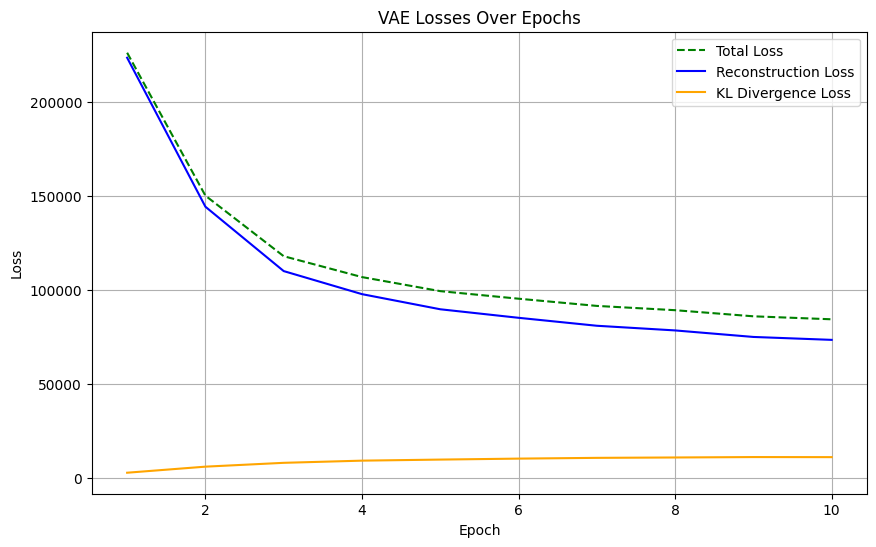

In [109]:
import matplotlib.pyplot as plt

# Assuming the loss values are collected during training
# For example, these are the loss values for each epoch
epochs = list(range(1, 11))  # Assuming 10 epochs
total_losses = [
    225968.4322, 149961.7283, 117777.1638, 106673.7010, 99196.6054, 
    95177.4467, 91348.9856, 89067.6916, 85818.6161, 84230.3667
]
reconstruction_losses = [
    223316.5410, 144085.7886, 109862.4376, 97603.3659, 89559.6548, 
    85025.4484, 80793.3108, 78311.7561, 74844.2225, 73293.4725
]
kl_losses = [
    2651.8907, 5875.9400, 7914.7262, 9070.3351, 9636.9502, 
    10151.9983, 10555.6744, 10755.9358, 10974.3938, 10936.8945
]

# Create a plot to visualize the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, total_losses, 'g--', label='Total Loss')  # Total loss (green dashed line)
plt.plot(epochs, reconstruction_losses, 'b-', label='Reconstruction Loss')  # Reconstruction loss (blue line)
plt.plot(epochs, kl_losses, 'orange', label='KL Divergence Loss')  # KL loss (orange line)

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses Over Epochs')

# Display legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


Observations:
The total loss is decreasing consistently, indicating that the model is improving.
The Reconstruction Loss is much higher than the KL loss, which is typical in the early stages of training. As the model becomes better at encoding and decoding the data, the reconstruction loss should continue to decrease.
The KL Loss appears to be stabilizing as the model tries to make the distribution of the latent variables closer to a standard normal distribution.

Epoch [1/50], Loss: 62661.8425, Reconstruction Loss: 55101.6012, KL Loss: 7560.2411
Epoch [2/50], Loss: 62181.7484, Reconstruction Loss: 54482.2346, KL Loss: 7699.5139
Epoch [3/50], Loss: 61855.8867, Reconstruction Loss: 54035.8178, KL Loss: 7820.0688
Epoch [4/50], Loss: 61531.5417, Reconstruction Loss: 53615.8132, KL Loss: 7915.7285
Epoch [5/50], Loss: 61174.9843, Reconstruction Loss: 53117.7319, KL Loss: 8057.2523
Epoch [6/50], Loss: 60949.7690, Reconstruction Loss: 52810.9466, KL Loss: 8138.8222
Epoch [7/50], Loss: 60547.5016, Reconstruction Loss: 52299.4696, KL Loss: 8248.0322
Epoch [8/50], Loss: 60363.6959, Reconstruction Loss: 52007.9735, KL Loss: 8355.7225
Epoch [9/50], Loss: 59770.3375, Reconstruction Loss: 51321.8903, KL Loss: 8448.4469
Epoch [10/50], Loss: 59405.6994, Reconstruction Loss: 50903.0323, KL Loss: 8502.6673
Epoch [11/50], Loss: 59266.0377, Reconstruction Loss: 50703.5238, KL Loss: 8562.5142
Epoch [12/50], Loss: 59050.6625, Reconstruction Loss: 50451.4270, KL Loss:

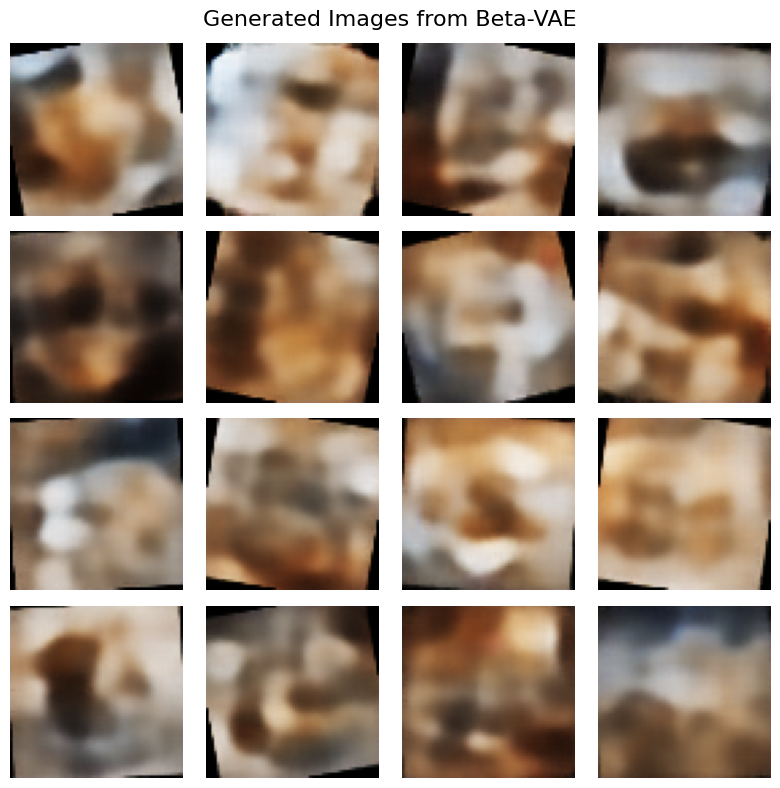

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import os

# Training loop for 50 epochs
epochs = 50
model.beta = 1.0  # Initial beta value (if annealing, add that logic here)
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    recon_loss = 0.0
    kl_loss = 0.0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(next(model.parameters()).device)  # Ensure data is on the same device as the model
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_x, mu, log_var = model(data)
        
        # Compute the loss
        mse, kl, total_loss = vae_loss_tanh(recon_x, data, mu, log_var, model.beta)
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Update loss values
        train_loss += total_loss.item()
        recon_loss += mse.item()
        kl_loss += kl.item()
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print statistics after each epoch
    avg_train_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss / len(train_loader)
    avg_kl_loss = kl_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, '
          f'Reconstruction Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')
    
    # Optionally save the model checkpoint at intervals
    
    

# Function to generate and visualize images
def generate_and_visualize_images(model, num_images=16):
    """
    Generate and visualize images using the trained Beta-VAE model.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(num_images, model.fc_mu.out_features).to(next(model.parameters()).device)
        
        # Decode latent vectors to generate images
        generated_images = model.decode(z).cpu()  # Ensure the output is on CPU
        generated_images = (generated_images + 1) / 2  # Rescale to [0, 1] for visualization

    # Plot generated images
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.axis('off')
    plt.suptitle('Generated Images from Beta-VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate and visualize images after training
generate_and_visualize_images(model, num_images=16)


Beta Annealing(Gradually Increase over epochs) with Step Schedule

Epoch [1/20], Loss: 81410.5333, Reconstruction Loss: 70455.5583, KL Loss: 10954.9751, Beta: 1.00
Epoch [2/20], Loss: 88998.0507, Reconstruction Loss: 73833.3630, KL Loss: 7981.4145, Beta: 1.90
Epoch [3/20], Loss: 94437.9643, Reconstruction Loss: 76538.2944, KL Loss: 6392.7396, Beta: 2.80
Epoch [4/20], Loss: 97980.6156, Reconstruction Loss: 78183.5874, KL Loss: 5350.5481, Beta: 3.70
Epoch [5/20], Loss: 101619.2554, Reconstruction Loss: 80161.0521, KL Loss: 4664.8269, Beta: 4.60
Epoch [6/20], Loss: 104232.2656, Reconstruction Loss: 81465.9845, KL Loss: 4139.3239, Beta: 5.50
Epoch [7/20], Loss: 106677.0720, Reconstruction Loss: 82993.0662, KL Loss: 3700.6257, Beta: 6.40
Epoch [8/20], Loss: 108734.7476, Reconstruction Loss: 84188.8275, KL Loss: 3362.4547, Beta: 7.30
Epoch [9/20], Loss: 110019.4654, Reconstruction Loss: 84848.0691, KL Loss: 3069.6825, Beta: 8.20
Epoch [10/20], Loss: 111991.5256, Reconstruction Loss: 86205.2911, KL Loss: 2833.6521, Beta: 9.10
Epoch [11/20], Loss: 113219.0861

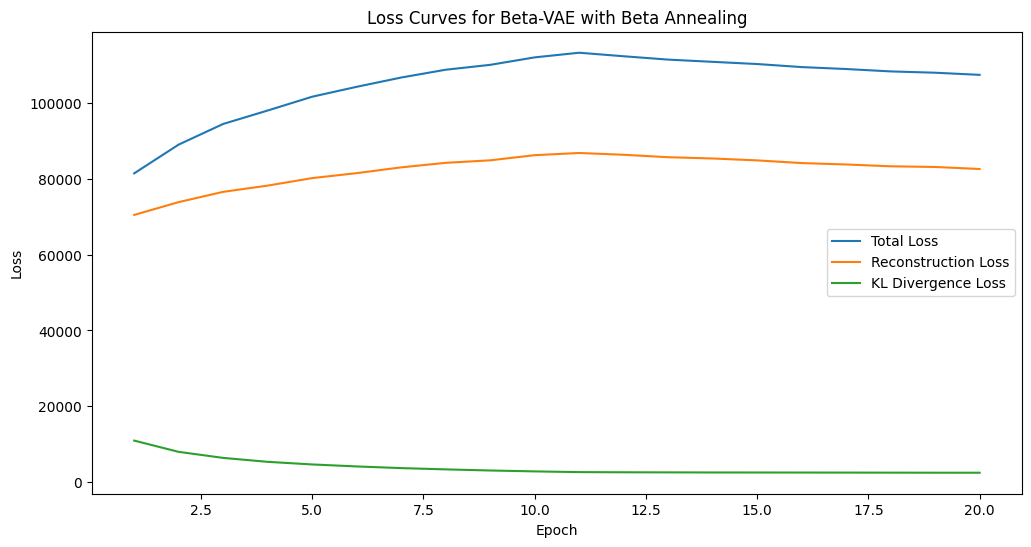

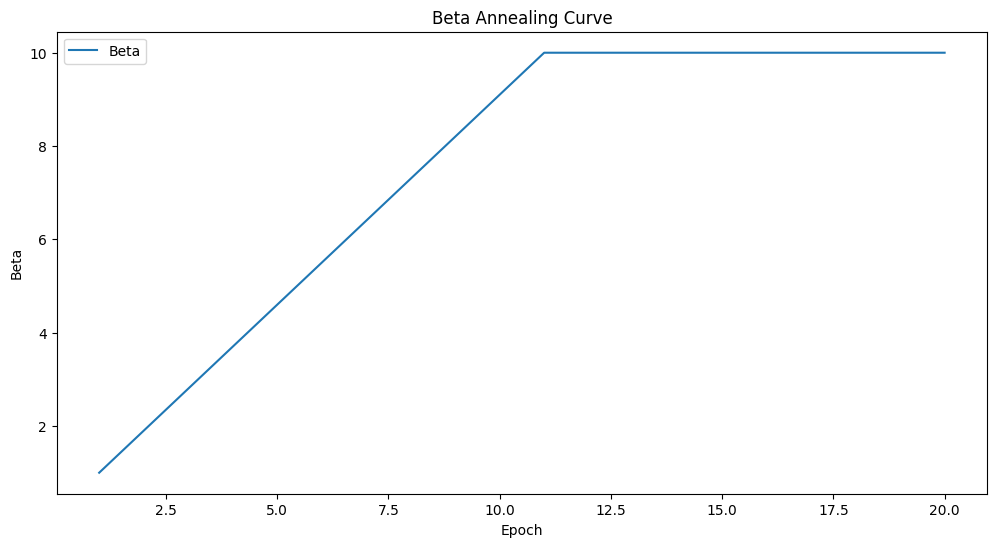

In [111]:
start_beta = 1.0
max_beta = 10.0
annealing_epochs = 10  # Number of epochs for beta annealing

# Training Loop
epochs = 20
train_losses, recon_losses, kl_losses, betas = [], [], [], []

for epoch in range(epochs):
    # Annealing step: Gradually increase beta
    if epoch < annealing_epochs:
        beta = start_beta + (max_beta - start_beta) * (epoch / annealing_epochs)
    else:
        beta = max_beta  # Keep it constant after annealing

    model.beta = beta  # Update the model with the new beta value
    betas.append(beta)

    model.train()  # Set model to training mode
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0

    for data, _ in train_loader:  # Assuming `data` is the input image batch
        optimizer.zero_grad()

        # Forward pass
        recon_x, mu, log_var = model(data)

        # Compute the loss
        mse, kl, total_loss = vae_loss_tanh(recon_x, data, mu, log_var, beta=model.beta)

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate loss statistics
        running_loss += total_loss.item()
        running_recon_loss += mse.item()
        running_kl_loss += kl.item()

    # Store losses for plotting
    train_losses.append(running_loss / len(train_loader))
    recon_losses.append(running_recon_loss / len(train_loader))
    kl_losses.append(running_kl_loss / len(train_loader))

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Reconstruction Loss: {running_recon_loss / len(train_loader):.4f}, "
          f"KL Loss: {running_kl_loss / len(train_loader):.4f}, Beta: {beta:.2f}")

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label='Total Loss')
plt.plot(range(1, epochs+1), recon_losses, label='Reconstruction Loss')
plt.plot(range(1, epochs+1), kl_losses, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for Beta-VAE with Beta Annealing')
plt.legend()
plt.show()

# Plot Beta annealing curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), betas, label='Beta')
plt.xlabel('Epoch')
plt.ylabel('Beta')
plt.title('Beta Annealing Curve')
plt.legend()
plt.show()

Beta Annealing Progress:

During the first 10 epochs, the beta value gradually increases from 1.0 to 10.0. This allows the model to focus more on the reconstruction loss at the start and then gradually emphasize the KL divergence for better latent space disentanglement.
Reconstruction Loss:

The reconstruction loss steadily decreases as the model becomes better at reconstructing the input data.
KL Divergence:

The KL divergence term initially decreases and then stabilizes as beta reaches its maximum value. This indicates that the latent space is being regularized appropriately.
Overall Loss:

The total loss initially increases during the annealing phase (due to the increasing weight of the KL divergence t

In [ ]:
model.save